# March 25, 28, 2022: lesion analysis

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import chain, combinations, islice
import scipy.sparse as sparse

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-03-28 21:08:19.959350: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-28 21:08:21.862225: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-28 21:08:21.911789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-28 21:08:21.912033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-28 21:08:21.912066: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## loading data and model

### data

In [2]:
def get_data_samples_actual(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(data[subject])
        y.append(np.repeat(target, num_samples, axis=0))

    return np.vstack(X), np.vstack(y)

def get_data_samples_avg(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(np.expand_dims(np.mean(data[subject], axis=0), axis=0))
        y.append(target)

    return np.vstack(X), np.vstack(y)

In [3]:
raw_data_file = f"{proj_dir}/data/classification_data/MAX_rois_122subjs_nearmiss_segments_withoutshock.pkl"
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

In [4]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

In [5]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[-args.num_test:]

X_train, y_train = get_data_samples_actual(data, train_list)
X_test, y_test = get_data_samples_actual(data, test_list)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2137, 12, 85) (2137, 12) (2167, 12, 85) (2167, 12)


2022-03-28 21:08:21.982855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 21:08:21.984513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-28 21:08:21.985341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-03-28 21:08:21.985430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-28 21:08:22.382134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

### model

In [6]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 100
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

In [7]:
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

In [8]:
tf.random.set_seed(args.SEED)

model_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_model"
history_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_model_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))

    # evaluate the model
    eval_hist = model.evaluate(X_test, y_test)
else:
    print(f"{model_file} is not saved")

2022-03-28 21:08:23.409130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-28 21:08:23.428079: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2022-03-28 21:08:23.736821: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


18/68 [======>.......................] - ETA: 0s - loss: 0.1301 - sparse_categorical_accuracy: 0.9938

2022-03-28 21:08:24.080370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


68/68 [==============================] - 1s 11ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9950


## lesion analysis

In [9]:
X = X_test.numpy().copy()

num_batch, num_time, num_rois = X.shape

roi_names_file = f"/home/govindas/parcellations/MAX_85_ROI_masks/ROI_names.txt"
roi_names = pd.read_csv(roi_names_file, delimiter='\t', header=None, names=['roi_name'])

# powerset of all combinations
def powerset(iterable, max_combs: int):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(max_combs+1))

records_file = f"{results_dir}/emoprox_appr_vs_retr/lesion/records.pkl"
if not os.path.exists(records_file):
    # fill in the dictionary
    records = {}
    pset = list(powerset(np.arange(0, num_rois, 1), max_combs=3))
    for rois_set in tqdm(pset):
        rois_set = list(rois_set)
        roi_names_set = tuple(roi_names.iloc[list(rois_set)]['roi_name'].values)

        X_abl = X.copy()
        X_abl[:, :, rois_set] = 0.0

        records[roi_names_set] = model.evaluate(X_abl, y_test, verbose=0)

    # save the dictionary
    with open(records_file, 'wb') as f:
        pickle.dump(records, f)
else:
    with open(records_file, 'rb') as f:
        records = pickle.load(f)

organize the roi sets in ascending order of accuracies.
so that we can see which rois decrease performance the most.

In [10]:
rois_records = {}
for idx in np.arange(0, num_rois, 1):
    x = {k:v[1] for k, v in records.items() if len(k) == idx}
    rois_records[f"rois_{idx}"] = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

### all rois

In [11]:
X_abl = X.copy()
X_abl[:, :, :] = 0.0
model.evaluate(X_abl, y_test, verbose=2)

68/68 - 1s - loss: 0.0289 - sparse_categorical_accuracy: 0.0000e+00


[0.028918983414769173, 0.0]

### single roi

Text(0, 0.5, 'accuracy')

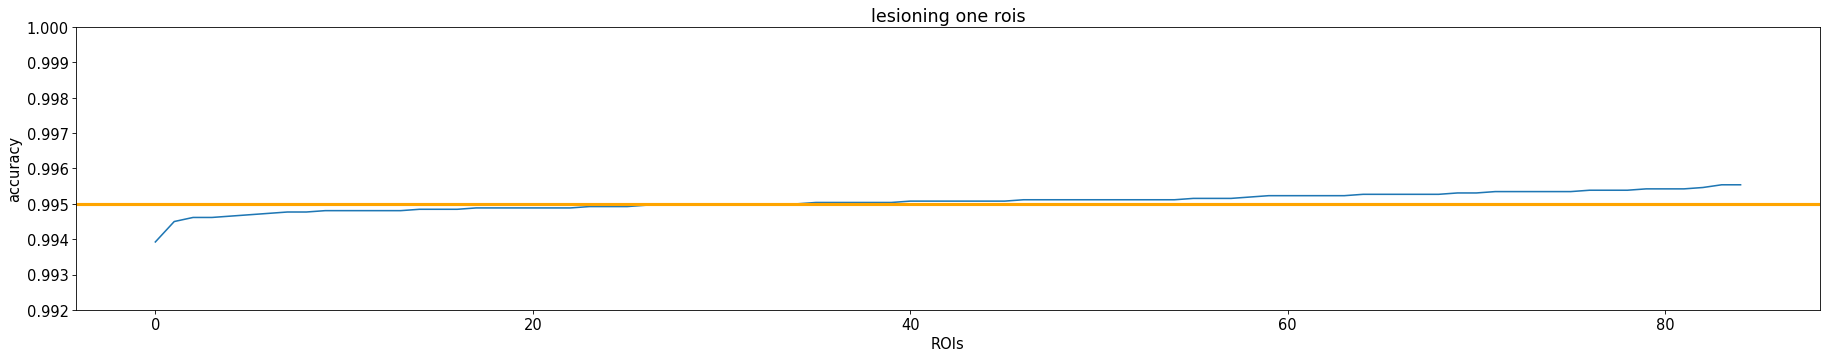

In [12]:
cm = 1 #1/2.54
nrows, ncols = 1, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(30*cm, 5*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

ax = axs

ax.set_title(f"lesioning one rois")

y_pts = list(rois_records['rois_1'].values())
ax.plot(y_pts)

ax.axhline(
    y=list(rois_records['rois_0'].values())[0], 
    color='orange', 
    linewidth=3.0)

ax.set_ylim(0.992, 1.0)

ax.set_xlabel(f"ROIs")
ax.set_ylabel(f"accuracy")

Text(0, 0.5, 'ROIs')

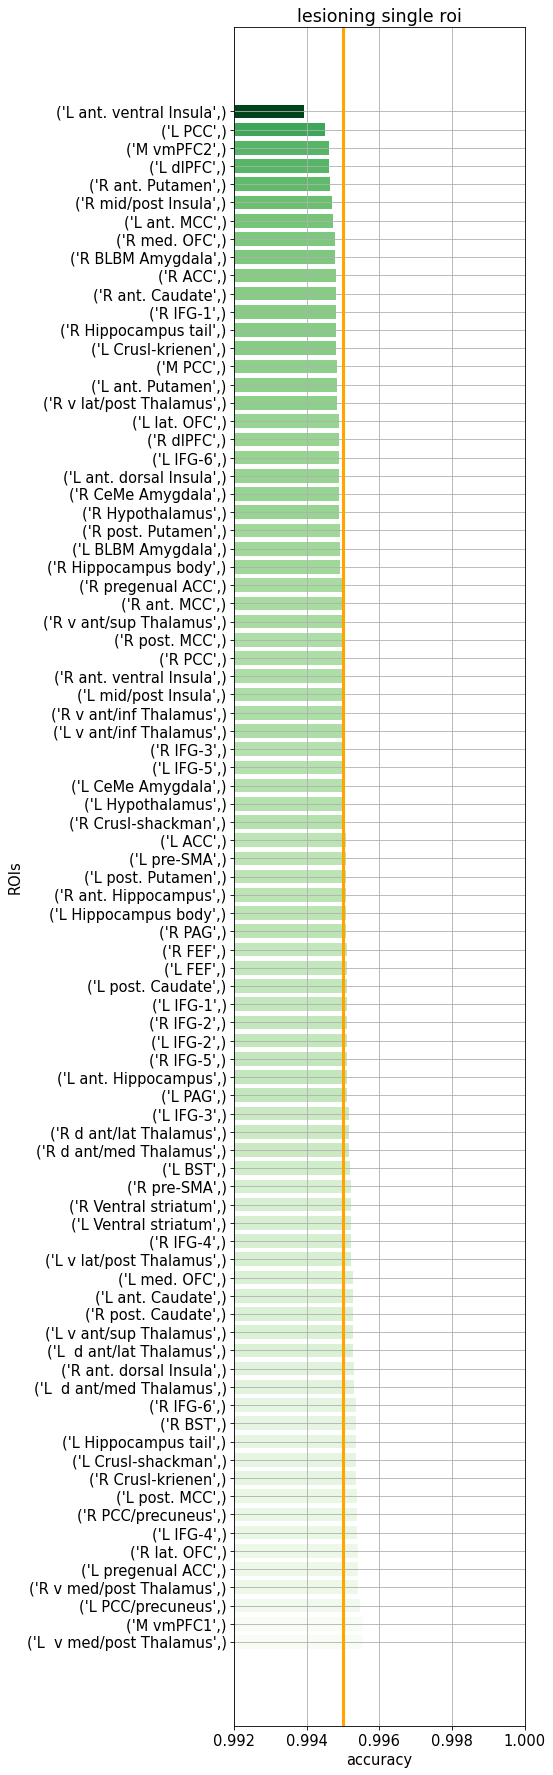

In [13]:
cm = 1 #1/2.54
nrows, ncols = 1, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*cm, 30*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

ax = axs
ax.set_title(f"lesioning single roi")

x_pts = list(rois_records['rois_1'].values())
ax.barh(
    y=np.arange(num_rois, 0, -1),
    width=x_pts, 
    height=0.75, 
    color=mpl.colormaps['Greens_r'](rescale(x_pts)))

ax.axvline(
    x=list(rois_records['rois_0'].values())[0], 
    color='orange', 
    linewidth=3.0)


# layout
ax.set_yticks(np.arange(num_rois, 0, -1))
ax.set_yticklabels(list(rois_records['rois_1'].keys()))
ax.set_xlim(0.992, 1.0)
ax.grid(True)

ax.set_xlabel(f"accuracy")
ax.set_ylabel(f"ROIs")
# ax.legend()

### two rois

Text(0, 0.5, 'accuracy')

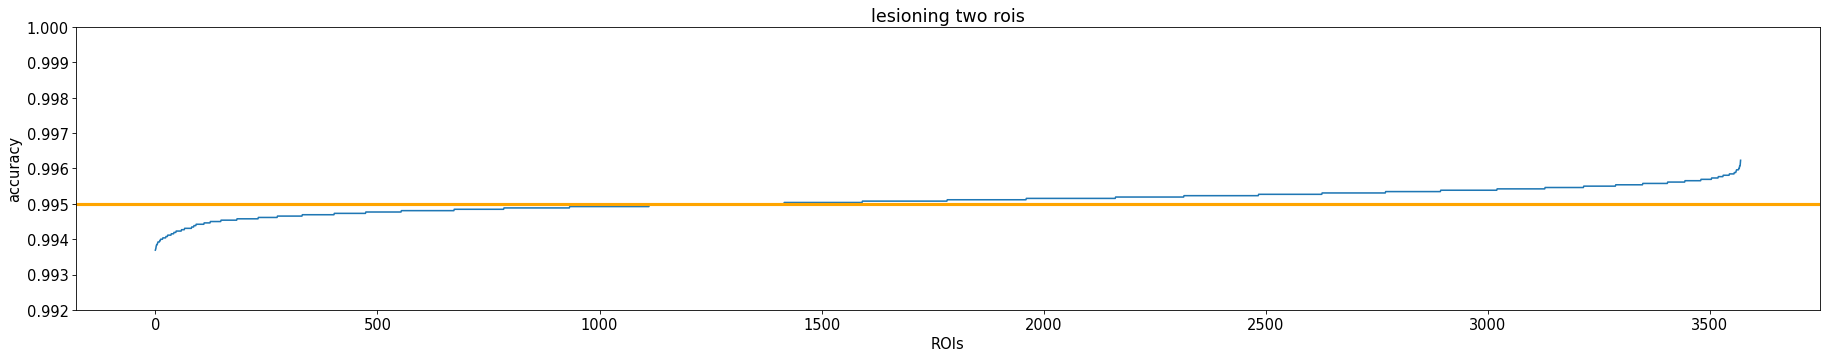

In [14]:
cm = 1 #1/2.54
nrows, ncols = 1, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(30*cm, 5*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

ax = axs

ax.set_title(f"lesioning two rois")

y_pts = list(rois_records['rois_2'].values())
ax.plot(y_pts)

ax.axhline(
    y=list(rois_records['rois_0'].values())[0], 
    color='orange', 
    linewidth=3.0)

ax.set_ylim(0.992, 1.0)

ax.set_xlabel(f"ROIs")
ax.set_ylabel(f"accuracy")

**Top 20 pairs of rois the model consideres as important**

In [15]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n = 20
n_items = take(n, rois_records['rois_2'].items())
n_items

[(('L PCC', 'L ant. ventral Insula'), 0.9936932921409607),
 (('L ant. ventral Insula', 'L ant. dorsal Insula'), 0.9937317371368408),
 (('L ant. ventral Insula', 'R mid/post Insula'), 0.9938086271286011),
 (('M vmPFC2', 'L ant. ventral Insula'), 0.9938470721244812),
 (('L ant. ventral Insula', 'R Hippocampus tail'), 0.9938470721244812),
 (('L ant. ventral Insula', 'R BLBM Amygdala'), 0.9938855767250061),
 (('L dlPFC', 'L ant. ventral Insula'), 0.9939240217208862),
 (('L ACC', 'L ant. ventral Insula'), 0.9939240217208862),
 (('L ant. Putamen', 'L ant. ventral Insula'), 0.9939240217208862),
 (('L ant. ventral Insula', 'L BLBM Amygdala'), 0.9939240217208862),
 (('L PCC', 'R mid/post Insula'), 0.9939624667167664),
 (('L ant. ventral Insula', 'R ant. Hippocampus'), 0.9939624667167664),
 (('R med. OFC', 'L ant. ventral Insula'), 0.9940009117126465),
 (('R post. MCC', 'L ant. ventral Insula'), 0.9940009117126465),
 (('L ant. ventral Insula', 'R Hippocampus body'), 0.9940009117126465),
 (('L an

### three rois

Text(0, 0.5, 'accuracy')

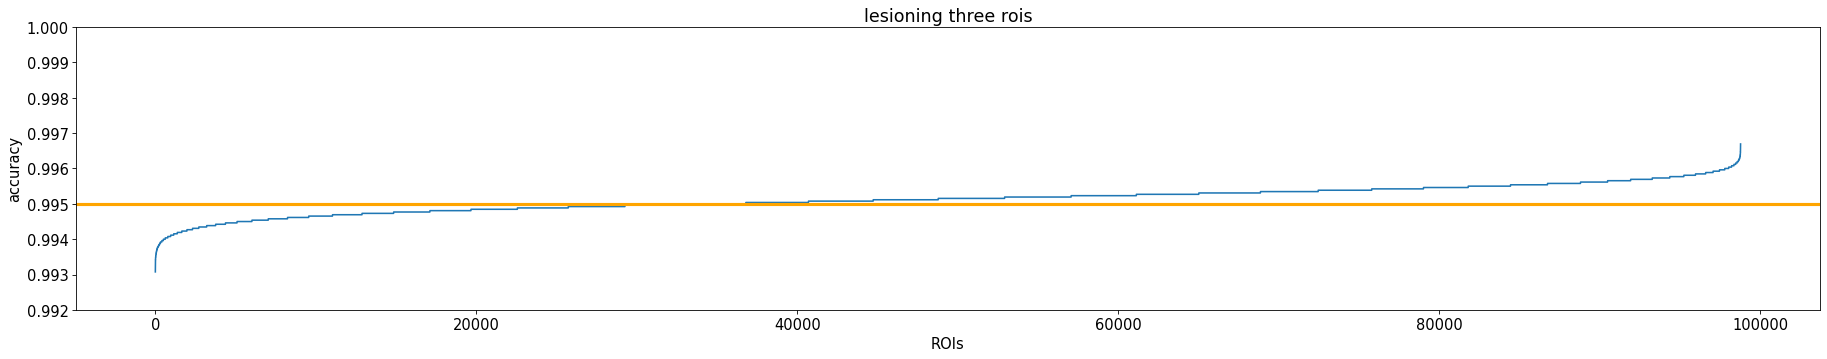

In [16]:
cm = 1 #1/2.54
nrows, ncols = 1, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(30*cm, 5*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

ax = axs

ax.set_title(f"lesioning three rois")

y_pts = list(rois_records['rois_3'].values())
ax.plot(y_pts)

ax.axhline(
    y=list(rois_records['rois_0'].values())[0], 
    color='orange', 
    linewidth=3.0)

ax.set_ylim(0.992, 1.0)

ax.set_xlabel(f"ROIs")
ax.set_ylabel(f"accuracy")

**Top 20 sets of rois the model assigns importance to**

In [17]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n = 20
n_items = take(n, rois_records['rois_3'].items())
n_items

[(('L PCC', 'L ant. ventral Insula', 'L ant. dorsal Insula'),
  0.9930779933929443),
 (('R IFG-1', 'L ant. ventral Insula', 'R ant. dorsal Insula'),
  0.9931933283805847),
 (('L PCC', 'R ant. Putamen', 'L ant. ventral Insula'), 0.9932318329811096),
 (('M vmPFC2', 'L ant. ventral Insula', 'L ant. dorsal Insula'),
  0.9932702779769897),
 (('R ant. Putamen', 'R IFG-5', 'L ant. ventral Insula'), 0.9932702779769897),
 (('R IFG-1', 'L ant. ventral Insula', 'L ant. dorsal Insula'),
  0.9933087229728699),
 (('R IFG-5', 'L ant. ventral Insula', 'R ant. dorsal Insula'),
  0.9933856129646301),
 (('L ant. ventral Insula', 'R ant. dorsal Insula', 'L ant. dorsal Insula'),
  0.9933856129646301),
 (('L PCC', 'L ant. ventral Insula', 'R mid/post Insula'), 0.993424117565155),
 (('R ant. Putamen', 'L ant. ventral Insula', 'L ant. dorsal Insula'),
  0.993424117565155),
 (('R ant. Putamen', 'L ant. ventral Insula', 'L BLBM Amygdala'),
  0.993424117565155),
 (('L IFG-5', 'L ant. ventral Insula', 'L ant. dor